<a href="https://www.kaggle.com/code/cherrlacharitha/ship-detection?scriptVersionId=128063142" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <a id="imports"></a>Installation and imports

We need to install the `rasterio` package to vectorize the raster masks into polygons.

In [1]:
!pip install rasterio

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

%matplotlib inline

In [3]:
# function to convert RLE mask into 2d pixel array
def encode_mask(mask, shape=(768,768)):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    s = mask.split()
    for i in range(len(s)//2):
        start = int(s[2*i]) - 1
        length = int(s[2*i+1])
        img[start:start+length] = 1
    return img.reshape(shape).T

In [4]:
# where is stored the source data
IMG_PATH = '../input/airbus-ship-detection/train_v2/'
RLE_PATH = '../input/airbus-ship-detection/train_ship_segmentations_v2.csv'

## Skip processing and jump to illustrations
<a href=#check>Click here</a> to skip the actual processing of RLE to OBBOX and jump directly to examples.

In [5]:
# read the RLE annotation in a Pandas DataFrame
rle_df = pd.read_csv(RLE_PATH)
rle_df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


# Processing annotations

In this section, we will convert:
- RLE encoded strings into masks, 
- then from masks to polygons, 
- from polygons to rectangle envelopes 
- and finally to rotated bounding boxes

This section is the core of the transformation. You should be able to follow each step. We preserve the annotation in case the RLE is void so that we know that this image has no annotation for the training of the classifier. 

- We first turn each RLE string into a mask with a single annotation using the above function, 
- then we use [`rasterio.features.shapes`](https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html) function to vectorize the annotation into a **GeoJSON** polygon
- then we use [`shapely.minimum_rotated_rectangle`](https://shapely.readthedocs.io/en/stable/constructive.html) function to get the rectangle envelope of the polygon
- and finally we use some simple trigonometry functions to compute center, size and angle of the oriented bounding box (source [here](https://datascience.stackexchange.com/questions/104200/how-to-convert-horizontal-bounding-box-coordinates-to-oriented-bounding-box-coor))

In [6]:
from tqdm import tqdm
from rasterio import features
from shapely.geometry import MultiPoint

lines = []
for row in tqdm(rle_df.itertuples(), total=len(rle_df)):
    if pd.isna(row.EncodedPixels):
        lines.append({
            "ImageId": row.ImageId,
            "EncodedPixels": np.nan,
            "xc": np.nan,
            "yc": np.nan, 
            "dx": np.nan,
            "dy": np.nan,
            "angle": np.nan
        })
        continue

    # convert RLE encoded pixels into binary mask
    mask = encode_mask(str(row.EncodedPixels), shape=(768,768))

    # vectorize mask into GeoJSON
    value = 0.0
    for polygon, value in list(features.shapes(mask)):
        if value == 1.0:
            break
    if value != 1.0:
        print('Error while vectorizing mask')

    # get oriented bounding box around shape
    coords = polygon['coordinates'][0]
    obbox = MultiPoint(coords).minimum_rotated_rectangle

    # get center of bounding box and correct for half a pixel
    xc, yc = list(obbox.centroid.coords)[0]
    xc, yc = xc - 0.5, yc - 0.5
    
    # get external coordinates of oriented rectangle
    # compute length, width and angle
    p1, p2, p3, p4, p5 = list((obbox.exterior.coords))
    dx = math.sqrt((p3[0] - p2[0])**2 + (p3[1] - p2[1])**2)
    dy = math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)
    angle = math.atan2((p3[1] - p2[1]), (p3[0] - p2[0]))
    #length = max(dx, dy)
    #height = min(dx, dy)
    
    # store in list
    lines.append({
        "ImageId": row.ImageId,
        "EncodedPixels": row.EncodedPixels,
        "xc": xc,
        "yc": yc, 
        "dx": dx,
        "dy": dy,
        "angle": angle
    })
    #print(lines)
    #break

# create DataFrame
obbox_df = pd.DataFrame(lines, columns=['ImageId', 'EncodedPixels', 'xc', 'yc', 'dx', 'dy', 'angle'])

100%|██████████| 231723/231723 [14:19<00:00, 269.45it/s]


The meaning of columns is the following:
- `ImageId` is name of an image from train dataset (https://www.kaggle.com/c/airbus-ship-detection/data);
- `EncodedPixels` is Run-Length Encoding of the mask; 
- `xc` and `yc` are X and Y coordinate of box center;
- `dx` and `dy` are length (or distance) of the box along X and Y axis; 
- and `angle` is the rotation angle of the box in radians.

The values `dx` and `dy` do not correspond to length and width as we do not know which one is the longest (see specific commented code above). Also note that there are interesting discussions about the various ways to measure the orientation of the bounding box. Please check [this page](https://mmrotate.readthedocs.io/en/latest/intro.html).

The CSV file is stored as a new dataset [here](https://www.kaggle.com/datasets/jeffaudi/airbus-ships-annotations-oriented-bounding-boxes). 

In [7]:
# check the resulting DataFrame
obbox_df.head()

,ImageId,EncodedPixels,xc,yc,dx,dy,angle
0,00003e153.jpg,NaN,NaN,NaN,NaN,NaN,NaN
1,0001124c7.jpg,NaN,NaN,NaN,NaN,NaN,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,395.367761,482.503889,34.044102,103.808051,-1.600200
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,479.960000,296.720000,9.000000,24.600000,2.214297
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,75.500000,381.000000,18.000000,9.000000,3.141593


In [8]:
# save the resulting dataframe on disk as a CSV
obbox_df.to_csv("airbus_ship_train_obbox.csv", 
                  sep=',', na_rep='', float_format="%.2f", header=True, index=False)


# Checking results

Here we will read again the oriented bounding boxes and define some display functions to visualize the result of the conversion.


In [9]:
# local file after processing
#BOXES_PATH = '/kaggle/working/airbus_ship_train_obbox.csv'

# access to file as a new dataset
BOXES_PATH = '/kaggle/input/airbus-ships-annotations-oriented-bounding-boxes/airbus_ship_train_obbox.csv'

box_df = pd.read_csv(BOXES_PATH)
box_df.head()

,ImageId,EncodedPixels,xc,yc,dx,dy,angle
0,00003e153.jpg,NaN,NaN,NaN,NaN,NaN,NaN
1,0001124c7.jpg,NaN,NaN,NaN,NaN,NaN,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,395.37,482.50,34.04,103.81,-1.60
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,479.96,296.72,9.00,24.60,2.21
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,75.50,381.00,18.00,9.00,3.14


In [10]:
#get bounding box for a mask
def get_bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

#add padding to the bounding box
def get_bbox_p(img, padding=5):
    x1,x2,y1,y2 = get_bbox(img)
    lx,ly = img.shape
    x1 = max(x1-padding,0)
    x2 = min(x2+padding+1, lx-1)
    y1 = max(y1-padding,0)
    y2 = min(y2+padding+1, ly-1)
    return x1,x2,y1,y2

#convert parameters of the box for plotting
def convert_box(box):
    rot1 = math.cos(box[4])
    rot2 = math.sin(box[4])
    bx1 = box[0] - 0.5*(box[2]*rot1 - box[3]*rot2)
    bx2 = box[1] - 0.5*(box[2]*rot2 + box[3]*rot1)
    return (bx1,bx2,box[2],box[3],box[4]*180.0/math.pi)

def get_rec(box,width=1):
    b = convert_box(box)
    return patches.Rectangle((b[0],b[1]),b[2],b[3],b[4],linewidth=width,edgecolor='g',facecolor='none')

In [11]:
#plot image, mask, zoomed image, and zoomed mask with rotating bounding boxes
def show_box(idx):
    row = box_df.iloc[idx]
    name, encoding, x, y, dx, dy, rot = row.ImageId, row.EncodedPixels, \
        row.xc, row.yc, row.dx, row.dy, row.angle
    
    image = np.asarray(Image.open(os.path.join(IMG_PATH,name)))
        
    if pd.isna(encoding): #empty image
        plt.title(idx)
        plt.imshow(image)
        plt.axis('off')
        return 

    mask = encode_mask(encoding)
    box = (x,y,dx,dy,rot)

    fig,ax = plt.subplots(2, 2, figsize=(16, 16))
    ax[0,0].imshow(image)
    ax[0,1].imshow(mask)
    ax[0,0].add_patch(get_rec(box))
    ax[0,1].add_patch(get_rec(box))
    
    y1,y2,x1,x2 = get_bbox_p(mask,10)
    box_c = (x-x1,y-y1,dx,dy,rot)
    ax[1,0].imshow(image[y1:y2,x1:x2,:])
    ax[1,1].imshow(mask[y1:y2,x1:x2])
    ax[1,0].add_patch(get_rec(box_c,3))
    ax[1,1].add_patch(get_rec(box_c,3))
    
    for item in ax.flatten():
        item.axis('off')

    plt.title(idx)
    plt.show()

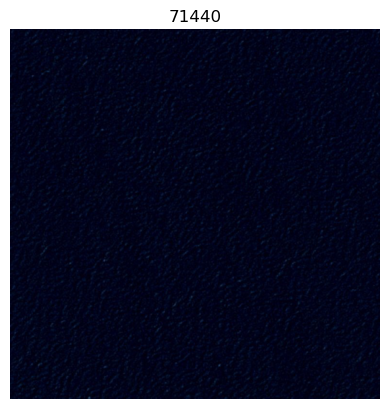

In [12]:
import random

# select a random image
idx = random.randrange(len(box_df))
show_box(idx)

# More examples of images with mask and oriented bounding box

Here we generate an overview and a close view of a random annotation with the associated vector annotation and mask annotation.

And here are a few interesting examples.

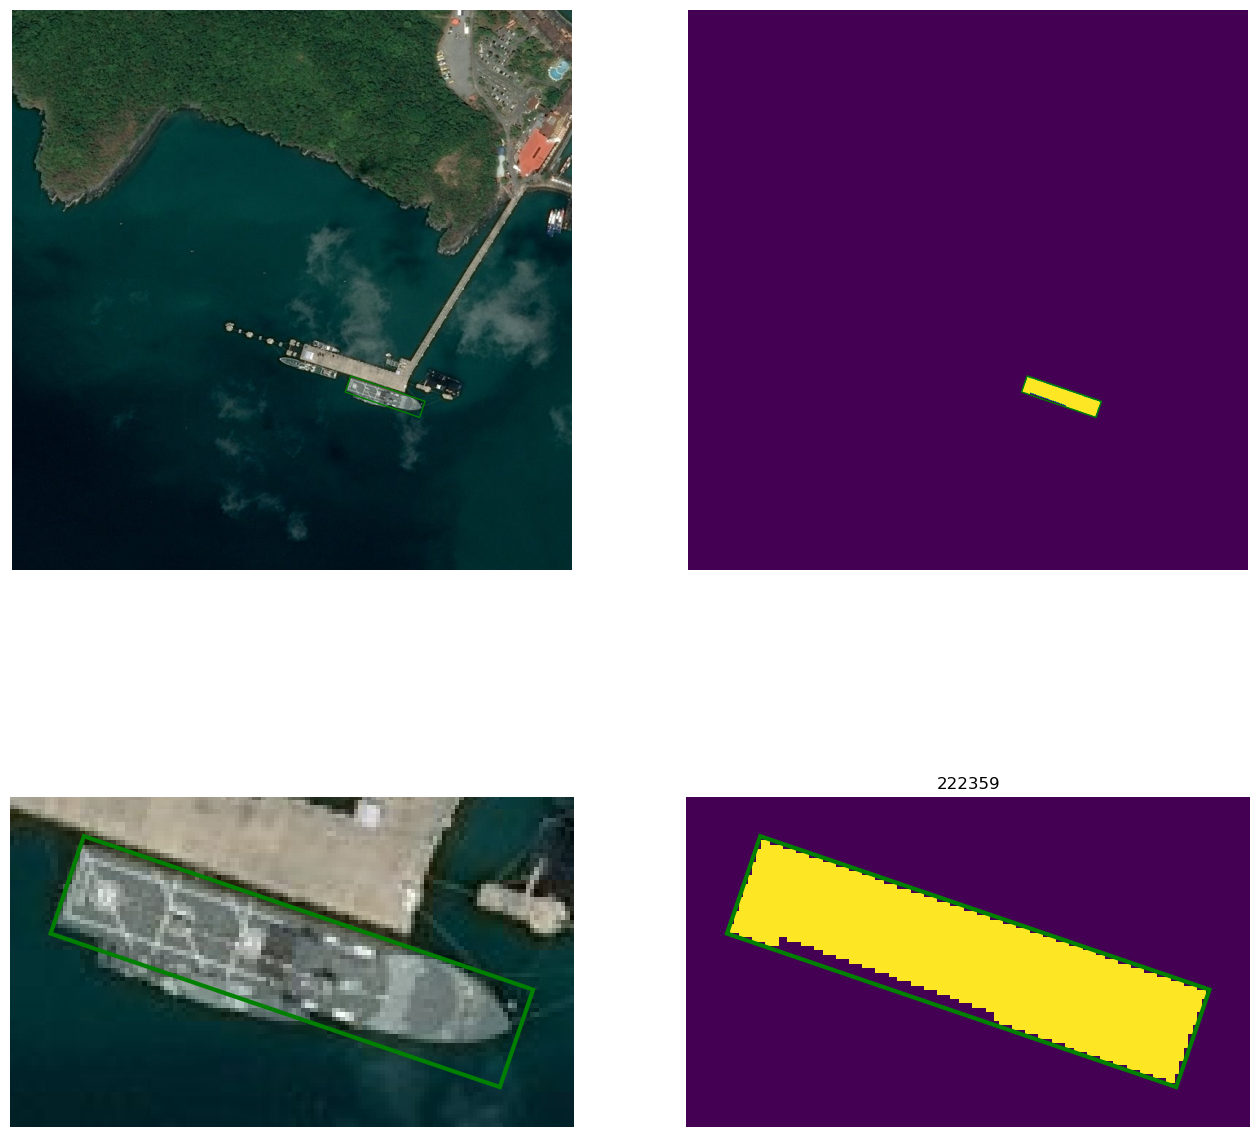

In [13]:
show_box(222359)

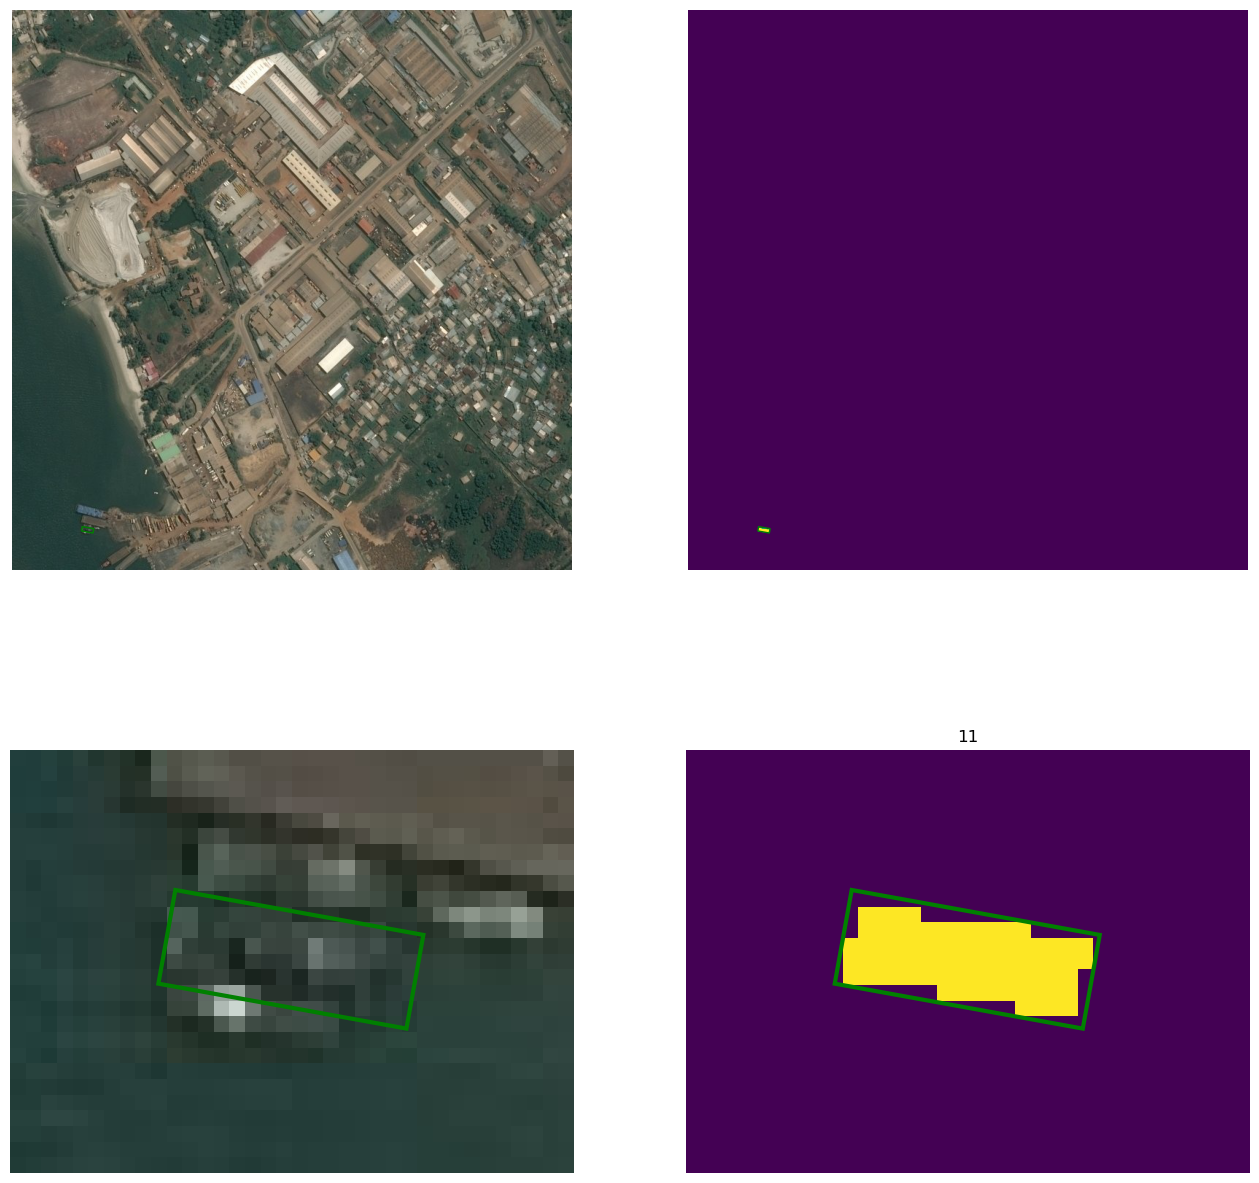

In [14]:
show_box(11)

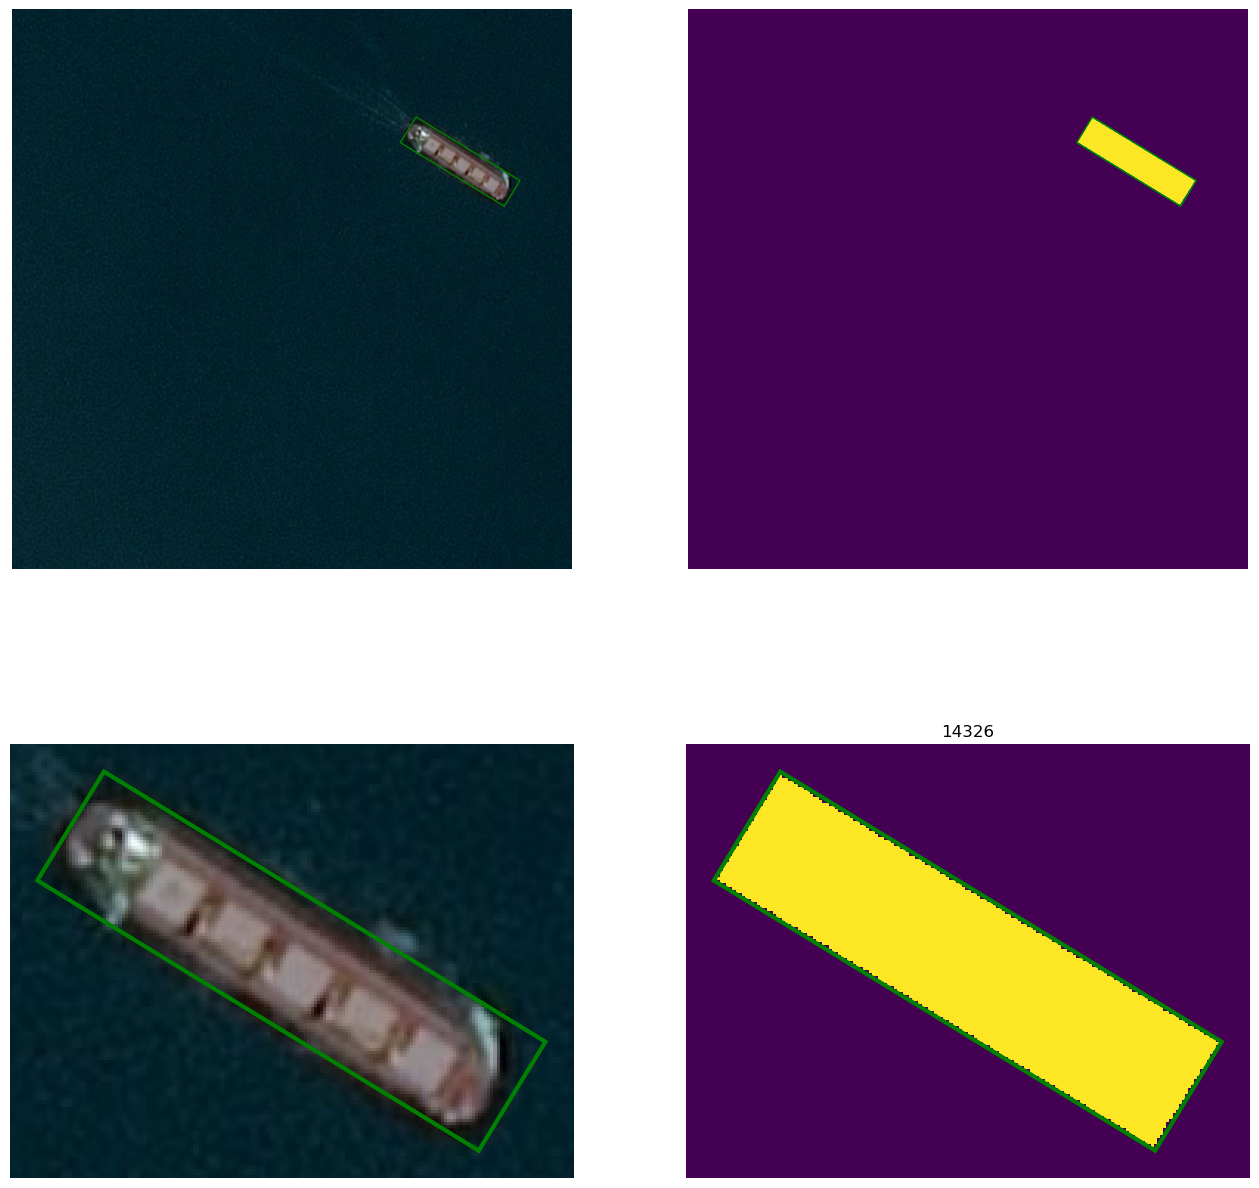

In [15]:
show_box(14326)

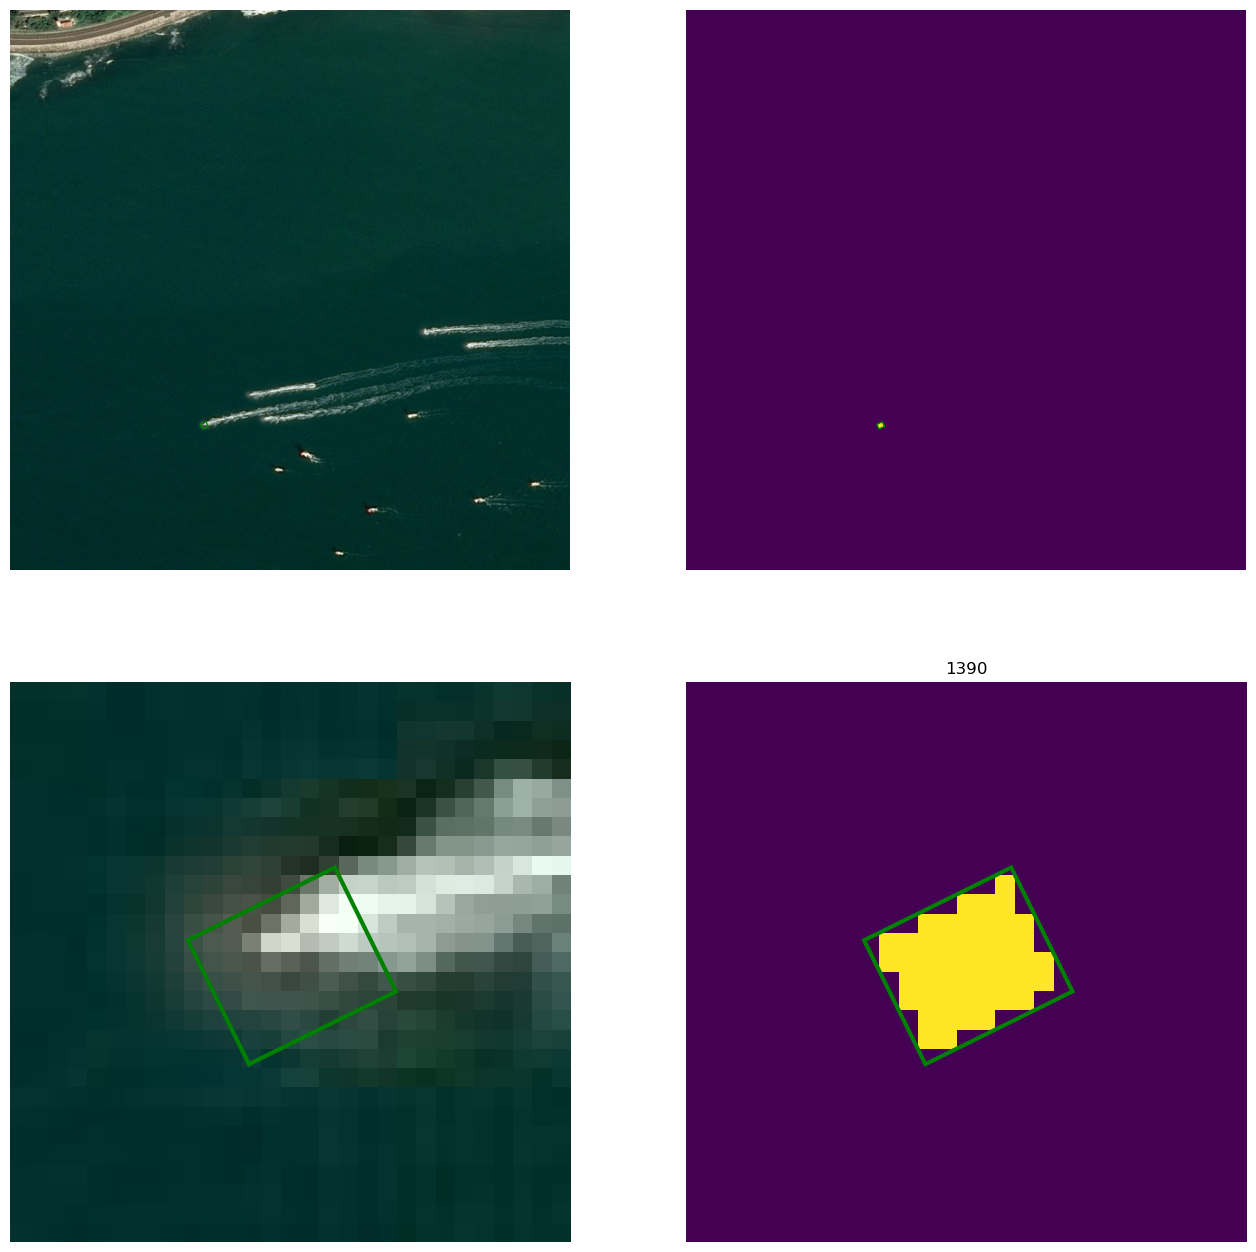

In [16]:
show_box(1390)

The final CSV file is stored as a new dataset [here](https://www.kaggle.com/datasets/jeffaudi/airbus-ships-annotations-oriented-bounding-boxes). 